In [1]:
# -*- coding: utf-8 -*-
import sys
import numpy as np
import pandas as pd
import cobra

print('Python version:', sys.version)
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('cobrapy version:', cobra.__version__)

Python version: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
numpy version: 1.16.4
pandas version: 0.24.2
cobrapy version: 0.15.4


In [2]:
def AddRxn(model, newRxnFile):
    """Function of adding new reactions to the model."""
    n1 = len(model.reactions)
    AllAddRxn = pd.read_csv(newRxnFile, sep=',', index_col='RxnID', skipinitialspace=True)
    n2 = len(AllAddRxn)
    for i in range(n2):
        ID = AllAddRxn.index.values[i]
        addRxn = cobra.Reaction(ID)
        model.add_reactions([addRxn])
        addRxnInf = model.reactions[n1 + i]
        addRxnInf.name = AllAddRxn.loc[ID, 'RxnName']
        addRxnInf.reaction = AllAddRxn.loc[ID, 'RxnFormula']
        addRxnInf.subsystem = AllAddRxn.loc[ID, 'Subsystem']
        addRxnInf.lower_bound = AllAddRxn.loc[ID, 'LowerBound']
        addRxnInf.upper_bound = AllAddRxn.loc[ID, 'UpperBound']
    return model


In [3]:
def KORxn(model, rxns2KO):
    """Function for knocking out reactions."""
    for ID in rxns2KO:
        reaction = model.reactions.get_by_id(ID)
        reaction.knock_out()


In [4]:
def flux2file(model, psw, save=False):
    """Function of exporting flux data."""
    if save:
        n = len(model.reactions)
        modelMatrix = np.empty([n, 9], dtype = object)
        for i in range(len(model.reactions)):
            x = model.reactions[i]
            modelMatrix[i, 0] = i + 1
            modelMatrix[i, 1] = x.id
            modelMatrix[i, 2] = x.name
            modelMatrix[i, 3] = x.reaction
            modelMatrix[i, 4] = x.subsystem
            modelMatrix[i, 5] = x.lower_bound
            modelMatrix[i, 6] = x.upper_bound
            modelMatrix[i, 7] = x.flux
            modelMatrix[i, 8] = abs(x.flux)
            
        df = pd.DataFrame(data = modelMatrix, 
                          columns = ['N', 'RxnID', 'RxnName', 'Reaction', 'SubSystem', 
                          'LowerBound', 'UpperBound', 'Flux-core', 'abs(Flux)'])
        df.to_excel('%s.xlsx' % psw, index=False)


In [5]:
def FBA(model, psw, save=False):
    solution = model.optimize()
    print("%s biomss: " %psw, round(solution.objective_value, 3))
    print("FDH flux: ", round(model.reactions.get_by_id('FDH').flux, 3))
    # export results
    flux2file(model, psw, save)
    return round(solution.objective_value, 3)



 ## Model background

 * Using E. coli full model iML1515.
 * Modified the transhydrogenase reaction (THD2pp) from 2 protons translocation to 1.
 * Changed HSDy (homoserine DH) to be irrversible, towards homoserine.
 * Changed MMM (Methylmalonyl-CoA mutase) to be reversible.
 * Base deletions: PFL, OBTFL, POR5 (pyruvate synthase, Ferredoxin), FDH4pp, FDH5pp, GLYCK (glycerate kinase, to 3pg), ATPM.
 * FolD is reversible, MTHFC and MTHFD.
 * FTL reaction is existed, FTHFLi (irrversible)
 * The model has part of the Ethylmalonyl-CoA pathway, ACACT1r, HACD1 and ECOAH1,
 propanoyl-CoA degradation, MMM and MMCD already.

In [6]:
model = cobra.io.load_json_model(r'..\0_ecoli_models\iML1515.json')

model.reactions.THD2pp.add_metabolites({"h_p": 1, "h_c": -1})
model.reactions.HSDy.bounds = (-1000, 0)
model.reactions.MMM.bounds = (-1000, 1000)

base deletions:

* POR5, GLYCK, FDH4pp, FDH5pp;
* ATPM;
* aerobic condition: PFL, OBTFL.

In [7]:
KORxn_base = ['POR5', 'GLYCK', 'FDH4pp', 'FDH5pp', 'ATPM', 'PFL', 'OBTFL']

KORxn(model, KORxn_base)

In [8]:
# Set medium: MeOH as sole the carbon source.
for rxn in model.boundary:
    if "C" in rxn.check_mass_balance(): # knock out all other carbon-related transporters
        rxn.bounds = (0., 1000)
model.reactions.get_by_id('EX_meoh_e').bounds = (-10., 1000)
model.reactions.get_by_id('EX_co2_e').bounds = (-1000, 1000)

In [9]:
# Homoserine cycle, with FDH
with model:
    model = AddRxn(model, 'NewRxns4Full_HomSer.csv')
    FBA(model, '1_HomoSer_FDH', save=True)


unknown metabolite 'hob_c' created
1_HomoSer_FDH biomss:  0.18
FDH flux:  0.569


In [10]:
# Homoserine cycle, try without FDH
with model:
    model = AddRxn(model, 'NewRxns4Full_HomSer.csv')
    KORxn(model, ['FDH'])
    FBA(model, '2_HomoSer_no_FDH', save=True)


unknown metabolite 'hob_c' created
2_HomoSer_no_FDH biomss:  0.179
FDH flux:  0.0


In [11]:
# then the sereine cycle, with FDH & ethylmalonyl-CoA pathway
with model:
    model = AddRxn(model, 'NewRxns4Full_SerCyc.csv')
    FBA(model, '3_SerCyc_FDH_etM', save=True)


unknown metabolite 'malylcoa_c' created
3_SerCyc_FDH_etM biomss:  0.163
FDH flux:  6.652


In [12]:
# try without FDH
with model:
    model = AddRxn(model, 'NewRxns4Full_SerCyc.csv')
    KORxn(model, ['FDH'])
    FBA(model, '4_SerCyc_etM', save=True)


unknown metabolite 'malylcoa_c' created
4_SerCyc_etM biomss:  0.117
FDH flux:  0.0


In [13]:
# try without ethylmalonyl-CoA pathway, to be fair with homoserine cycle
with model: 
    model = AddRxn(model, 'NewRxns4Full_SerCyc.csv')
    KORxn(model, ['EtMaCoA'])
    FBA(model, '5_SerCyc_FDH_no_etM', save=True)


unknown metabolite 'malylcoa_c' created
5_SerCyc_FDH_no_etM biomss:  0.159
FDH flux:  5.881


In [14]:
# try without FDH & ethylmalonyl-CoA pathway
with model: 
    model = AddRxn(model, 'NewRxns4Full_SerCyc.csv')
    KORxn(model, ['FDH','EtMaCoA'])
    FBA(model, '6_SerCyc_no_FDH_no_etM', save=True)


unknown metabolite 'malylcoa_c' created
6_SerCyc_no_FDH_no_etM biomss:  0.117
FDH flux:  0.0


In [15]:
# the modified serine cylce, with FDH
with model:
    model = AddRxn(model, 'NewRxns4Full_MSerCyc.csv')
    FBA(model, '7_MSerCyc_with_FDH', save=True)


unknown metabolite 'malylcoa_c' created
7_MSerCyc_with_FDH biomss:  0.148
FDH flux:  6.178


In [16]:
# the modified serine cylce, try without FDH
with model:
    model = AddRxn(model, 'NewRxns4Full_MSerCyc.csv')
    KORxn(model, ['FDH'])
    FBA(model, '8_MSerCyc_without_FDH', save=True)


unknown metabolite 'malylcoa_c' created
8_MSerCyc_without_FDH biomss:  0.107
FDH flux:  0.0


In [17]:
# The RuMP pathway, try with FDH
with model:
    model = AddRxn(model, 'NewRxns4Full_RuMP.csv')
    FBA(model, '9_RuMP_with_FDH', save=True)


unknown metabolite 'h6p_c' created
9_RuMP_with_FDH biomss:  0.216
FDH flux:  0.001


In [18]:
with model:
    model = AddRxn(model, 'NewRxns4Full_RuMP.csv')
    KORxn(model, ['FDH'])
    FBA(model, '10_RuMP_without_FDH', save=True)


unknown metabolite 'h6p_c' created
10_RuMP_without_FDH biomss:  0.216
FDH flux:  0.0


 # Summary:
 * In Homoserine cycle (result 1)

 The model uses most of MeOH to produce biomass, only 0.569/10 = **5.7%** was directly oxidased
 by FDH for the electrons.
 Formate here is produced from C1 by purU (FTHFD).

 The value of biomass function is 0.180. Then the biomass yield is **18.0 gDW/mol** MeOH.

 If no FDH (result 2), biomass yield is **17.9 gDW/mol** MeOH.
 The model uses akg DH (AKGDH) to get electrons, 3.2%.

 * In Serine cycle (result 5)

 The model oxidases most of formate by FDH, 5.881/10 = **58.8%**.

 The value of biomass function is 0.159, Then the biomass yield is **15.9 gDW/mol** MeOH.

 * In the modified serine cycle (result 7)

 The model oxiases even more foramte, 6.178/10 = **61.8%**.

 The value of biomass function is 0.148. Then the biomass yield is **14.8 gDW/mol** MeOH.

 * In the RuMP cycle (result 9)

 The pathway does not need FDH.

 The value of biomass function is 0.216. Then the biomass yield is **21.6 gDW/mol** MeOH.

 ----
 *Note*: The unit for carbon source uptake is mmol/gDW/h. Biomass function is then growth rate h<sup>-1</sup>.
 Growth rate/uptake rate = mgDW/mmol = gDW/mol. (ATPM is KO)

In [19]:
from matplotlib import pyplot as plt
plt.rc('axes', axisbelow=True)

psw = ('RuMP', 'SerCyc','MSerCyc','HomS')
FDH = (0, 58.8, 61.8, 5.7)
BioYield = (21.6, 15.9, 14.8, 18.0)


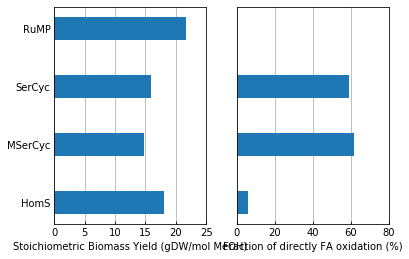

In [20]:
fig, ax = plt.subplots(1,2,sharey=True)
y_pos = np.arange(len(psw))
ax[0].invert_yaxis()
ax[0].barh(y_pos, BioYield,height=0.4)
ax[0].set_xlabel('Stoichiometric Biomass Yield (gDW/mol MeOH)')
ax[0].set_xlim([0,25])
ax[0].tick_params(direction='in')
ax[0].set_yticks(y_pos)
ax[0].tick_params(axis='y',width=0)
ax[0].set_yticklabels(psw)
ax[0].grid(True, axis='x')

ax[1].barh(y_pos, FDH, height=0.4)
ax[1].tick_params(direction='in')
ax[1].tick_params(axis='y',width=0)
ax[1].set_xlabel('Fraction of directly FA oxidation (%)')
ax[1].set_xlim([0,80])
ax[1].grid(True, axis='x')

plt.show()

In [21]:
fig.savefig('homoserine_biomass_modelling.eps')